## Projeção Perspectiva

In [1]:
from pathlib import Path
from skimage import io, transform
import numpy as np
from numpy.linalg import solve
from matplotlib import pyplot as plt
from typing import Tuple

In [2]:
def gmt_bilinear_interpolation(image: np.ndarray, x_o: float, y_o: float) -> float:
    """Apply a bilinear interpolation to a pixel of an image.
    
    Parameters:
        image: input image
        x_o: x coordinate of the pixel
        y_o: y coordinate of the pixel
    Returns:
        pixel: interpolated pixel
    """
    
    # Get the coordinates of the pixels
    rows, cols = image.shape
    x_o = np.clip(x_o, 0, cols - 1)
    y_o = np.clip(y_o, 0, rows - 1)
    x_i, y_i = int(x_o), int(y_o)

    # Get the four pixels
    p1 = image[y_i, x_i]
    p2 = image[y_i, x_i + 1]
    p3 = image[y_i + 1, x_i]
    p4 = image[y_i + 1, x_i + 1]

    # Get the distances
    dx = x_o - x_i
    dy = y_o - y_i

    weights = np.array([
        (1 - dx)*(1 - dy),
        dx*(1 - dy),
        (1 - dx)*dy,
        dx*dy
    ])

    neighbors = np.array([p1, p2, p3, p4])
    pixel = weights @ neighbors.T
    return pixel

def gmt_bilinear_interpolation_vet(
    image: np.ndarray,
    coords: np.ndarray,
    shape: Tuple[int, int]
) -> np.ndarray:
    """Apply a bilinear interpolation to a pixel of an image.
    
    Parameters:
        image: input image
        coords: coordinates of the pixel
        shape: shape of the output image
    Returns:
        image_blnr: interpolated image
    """

    # Get the coordinates of the pixels
    rows, cols = image.shape
    x_o, y_o = coords
    x_o = np.clip(x_o, 0, cols - 1)
    y_o = np.clip(y_o, 0, rows - 1)

    # Get the coordinates of the neighbor
    x_n = np.floor(x_o).astype(np.uint32)
    y_n = np.floor(y_o).astype(np.uint32)


    # Get the distances
    dx = x_o - x_n
    dy = y_o - y_n

    # Get the weights of the pixels
    weights = np.array([
        (1 - dx)*(1 - dy),
        dx*(1 - dy),
        (1 - dx)*dy,
        dx*dy
    ])

    xn_1 = np.where(x_n + 1 < cols - 1, x_n + 1, cols - 1)
    yn_1 = np.where(y_n + 1 < rows - 1, y_n + 1, rows - 1)

    # Get the neighborhood of the pixel
    neighborhood = np.vstack((
        image[y_n, x_n],
        image[y_n, xn_1],
        image[yn_1, x_n],
        image[yn_1, xn_1]
    ))

    image_blnr = np.sum(weights * neighborhood, axis=0)
    return image_blnr.reshape(shape).astype(image.dtype)

In [3]:
def warp_naive(
    image: np.ndarray, gmt: np.ndarray, inverse: bool = False
) -> np.ndarray:
    """Apply a geometric transformation to an image.

    Parameters:
        image: input image
        gmt: transformation matrix (3x3)
        inverse: if True, apply the inverse transformation
    Returns:
        t_image: transformed image
    """

    t_image = np.zeros_like(image)

    # (x_i, y_i, w) = transform * (x_o, y_o, 1)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Get the coordinates of the transformed pixel
            coords = gmt @ np.array([x, y, 1])

            # Normalize the coordinates (x, y, w) -> (x/w, y/w, 1)
            x_t, y_t, _ = coords / coords[2]

            # Check if the pixel is inside the image
            inside = (
                (x_t >= 0)
                & (y_t >= 0)
                & (x_t < image.shape[1])
                & (y_t < image.shape[0])
            )
            if not inside:
                continue

            # Get the pixel value
            # print(int(round(x_t)), int(round(y_t)))
            if inverse:
                # t_image[y, x] = image[int(y_t), int(x_t)]
                t_image[y, x] = gmt_bilinear_interpolation(image, x_t, y_t)
            else:
                # t_image[int(y_t), int(x_t)] = image[y, x]
                t_image[int(y_t), int(x_t)] = gmt_bilinear_interpolation(image, x, y)

    return t_image


def warp_vet(
    image: np.ndarray, gmt: np.ndarray, inverse: bool = False
) -> np.ndarray:
    """Apply a geometric transformation to an image.
    (Vectorized version)
    Parameters:
        image: input image
        gmt: transformation matrix (3x3)
        inverse: if True, apply the inverse transformation
    Returns:
        t_image: transformed image
    """

    # Get the coordinates of the pixels
    rows, cols = image.shape
    indeces = np.indices((rows, cols))
    # coord = (x, y, 1)
    coords = np.vstack(
        (
            indeces[1].ravel(),
            indeces[0].ravel(),
            np.ones(rows * cols, dtype=np.int32),
        )
    )

    # Apply the transformation
    t_coords = gmt @ coords
    t_coords = (t_coords[:2] / t_coords[2])
    # t_coords = np.round(t_coords[:2] / t_coords[2]).astype(np.int32)

    # Create the transformed image
    t_image = np.zeros_like(image)
    # Check if the pixel is inside the image
    inside = (
        (t_coords[0] >= 0)
        & (t_coords[1] >= 0)
        & (t_coords[0] < cols)
        & (t_coords[1] < rows)
    )
    if inverse:
        t_image = (
            gmt_bilinear_interpolation_vet(image, t_coords, image.shape)
        )
    else:
        t_coords = np.round(t_coords).astype(np.int32)
        t_image[t_coords[1][inside], t_coords[0][inside]] = image[
            coords[1][inside], coords[0][inside]
        ]

    return t_image

### Perspective Transform

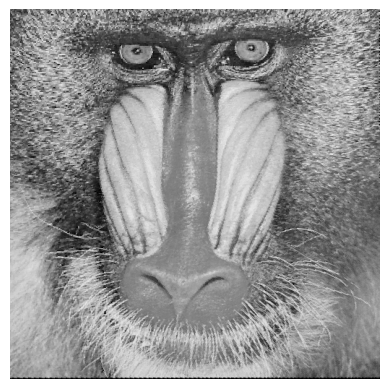

In [5]:
# Path to the images
images_path = Path('images')

# Read the images
image = io.imread(images_path / 'baboon_perspectiva.png')
image = image[:, :, 0]

# Define os pontos de origem e destino
src = np.array([[0, 0], [511, 0], [511, 511], [0, 511]])
dst = np.array([[37, 51], [342, 42], [485, 467], [73, 380]])

# Cria a matriz de coeficientes do sistema de equações
A = np.zeros((8, 8))
for i in range(4):
    A[i * 2, :] = [
        src[i, 0],
        src[i, 1],
        1,
        0,
        0,
        0,
        -dst[i, 0] * src[i, 0],
        -dst[i, 0] * src[i, 1],
    ]
    A[i * 2 + 1, :] = [
        0,
        0,
        0,
        src[i, 0],
        src[i, 1],
        1,
        -dst[i, 1] * src[i, 0],
        -dst[i, 1] * src[i, 1],
    ]

# Cria o vetor de soluções do sistema de equações
b = np.zeros((8,))
for i in range(4):
    b[i * 2] = dst[i, 0]
    b[i * 2 + 1] = dst[i, 1]

# Resolve o sistema de equações
h = solve(A, b)

# Cria a matriz de projeção perspectiva
H = np.zeros((3, 3))
H[0, :] = h[:3]
H[1, :] = h[3:6]
H[2, :2] = h[6:]
H[2, 2] = 1

# Aplicar a transformação perspectiva usando a função do skimage
tform = transform.ProjectiveTransform()
tform.estimate(src, dst)
image_transformed_1 = transform.warp(image, tform)

# Mostrar as imagens
# plt.imshow(image_transformed_1, cmap='gray')
# plt.axis('off')
# plt.show()

# image_transformed_2 = warp_naive(image, H, inverse=True)
# plt.imshow(image_transformed_2, cmap='gray')
# plt.axis('off')
# plt.show()

image_transformed_3 = warp_vet(image, H, inverse=True)
plt.imshow(image_transformed_3, cmap='gray')
plt.axis('off')
plt.show()

### Others

In [69]:
from typing import Tuple
def gmt_coords(
        rows:int, cols:int, gmt: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """Get the coordinates to apply a geometric transformation to an image.

    Parameters:
        rows: number of rows of the image
        cols: number of columns of the image
        gmt: transformation matrix (3x3)
    Returns:
        tuple:
            coords: coordinates of the transformed pixels
            t_coords: transformed coordinates
    """

    # Get the coordinates of the pixels
    indeces = np.indices((rows, cols))
    # coord = (x, y, 1)
    coords = np.vstack(
        (
            indeces[1].ravel(),
            indeces[0].ravel(),
            np.ones(rows * cols, dtype=np.int32),
        )
    )

    # Apply the transformation
    t_coords = gmt @ coords

    # Normalize the coordinates
    t_coords = (t_coords[:2] / t_coords[2])

    # Return the coordinates of the pixels (x, y)
    return coords[:2], t_coords

def gmt_bilinear_interpolation(
        image: np.ndarray,
        coords: np.ndarray,
        shape: Tuple[int, int]
) -> np.ndarray:
    """Apply a bilinear interpolation to a pixel of an image.
    
    Parameters:
        image: input image
        coords: coordinates of the pixel
        shape: shape of the output image
    Returns:
        image_blnr: interpolated image
    """

    # Get the coordinates of the pixels
    rows, cols = image.shape
    x_o, y_o = coords
    x_o = np.clip(x_o, 0, cols - 1)
    y_o = np.clip(y_o, 0, rows - 1)

    # Get the coordinates of the neighbor
    x_n = np.floor(x_o).astype(np.uint32)
    y_n = np.floor(y_o).astype(np.uint32)


    # Get the distances
    dx = x_o - x_n
    dy = y_o - y_n

    # Get the weights of the pixels
    weights = np.array([
        (1 - dx)*(1 - dy),
        dx*(1 - dy),
        (1 - dx)*dy,
        dx*dy
    ])

    xn_1 = np.where(x_n + 1 < cols - 1, x_n + 1, cols - 1)
    yn_1 = np.where(y_n + 1 < rows - 1, y_n + 1, rows - 1)
    # print(xn_1.max(), yn_1.max())

    # xn_1 = x_n + 1
    # yn_1 = y_n + 1

    # padded_image = np.pad(image, ((1, 1), (1, 1)), mode='edge')


    # Get the neighborhood of the pixel
    neighborhood = np.vstack((
        image[y_n, x_n],
        image[y_n, xn_1],
        image[yn_1, x_n],
        image[yn_1, xn_1]
    ))

    image_blnr = np.sum(weights * neighborhood, axis=0)
    return image_blnr.reshape(shape).astype(image.dtype)

In [77]:
def gmt_nearest_neighbor_interpolation(
    image: np.ndarray,
    coords: np.ndarray,
    shape: Tuple[int, int]
) -> np.ndarray:
    """Apply a nearest neighbor interpolation to a pixel of an image.
    
    Parameters:
        image: input image
        coords: coordinates of the pixel
        shape: shape of the output image
    Returns:
        image_blnr: interpolated image
    """

    # Get the coordinates of the pixels
    rows, cols = image.shape
    x_o, y_o = coords
    x_o = np.clip(x_o, 0, cols - 1)
    y_o = np.clip(y_o, 0, rows - 1)

    # Get the coordinates of the neighbor
    x_n = np.round(x_o).astype(np.uint32)
    y_n = np.round(y_o).astype(np.uint32)

    image_blnr = image[y_n, x_n]
    return image_blnr.reshape(shape).astype(image.dtype)

In [46]:
def bicubic_interpolation(image, x, y):
    # Get the dimensions of the image
    height, width = image.shape

    # Compute the indices of the surrounding 16 pixels
    x_indices = np.floor(x).astype(int) + np.array([-1, 0, 1, 2])
    y_indices = np.floor(y).astype(int) + np.array([-1, 0, 1, 2])

    # Clip the indices to the image dimensions
    x_indices = np.clip(x_indices, 0, width - 1)
    y_indices = np.clip(y_indices, 0, height - 1)

    # Compute the fractional part of the indices
    x_frac = x - x_indices[1]
    y_frac = y - y_indices[1]

    # Compute the 16 weights for each pixel
    weights_x = np.array([bicubic_weight(x_frac[i]) for i in range(4)])
    weights_y = np.array([bicubic_weight(y_frac[i]) for i in range(4)])
    weights = np.outer(weights_y, weights_x).flatten()

    # Compute the indices of the 16 pixels in the flattened image
    pixel_indices = np.ravel_multi_index(
        (y_indices[:, None], x_indices), image.shape
    )

    # Extract the 16 pixels from the image and reshape them into a 4x4 grid
    pixels = image.flat[pixel_indices].reshape((4, 4))

    # Compute the interpolated pixel value
    interpolated_pixel = np.sum(weights * pixels.flatten())

    return interpolated_pixel


def bicubic_weight(x):
    if abs(x) <= 1:
        return (1.5 * abs(x) - 2.5) * abs(x) ** 2 + 1
    elif abs(x) <= 2:
        return ((-0.5 * abs(x) + 2.5) * abs(x) - 4) * abs(x) + 2
    else:
        return 0

In [99]:
def gmt_bicubic_interpolation(
    image: np.ndarray,
    coords: np.ndarray,
    shape: Tuple[int, int]
) -> np.ndarray:
    """Apply a bicubic interpolation to a pixel of an image.
    
    Parameters:
        image: input image
        coords: coordinates of the pixel
        shape: shape of the output image
    Returns:
        image_bicubic: interpolated image
    """

    # Get the coordinates of the pixels
    rows, cols = image.shape
    x_o, y_o = coords
    x_o = np.clip(x_o, 1, cols - 3)
    y_o = np.clip(y_o, 1, rows - 3)

    # Get the coordinates of the neighbors
    x_n = np.floor(x_o).astype(np.uint32)
    y_n = np.floor(y_o).astype(np.uint32)

    # Get the distances
    dx = x_o - x_n
    dy = y_o - y_n

    # Get the weights of the pixels
    weights_x = cubic_weight(np.expand_dims(dx, axis=0) - np.arange(4) + 1)
    weights_y = cubic_weight(np.expand_dims(dy, axis=1) - np.arange(4) + 1)

    # Ensure that the coordinates are inside the image
    xn_1 = np.where(x_n + 1 < cols - 1, x_n + 1, cols - 1)
    xn_2 = np.where(x_n + 2 < cols - 1, x_n + 2, cols - 1)
    xn_3 = np.where(x_n + 3 < cols - 1, x_n + 3, cols - 1)
    yn_1 = np.where(y_n + 1 < rows - 1, y_n + 1, rows - 1)
    yn_2 = np.where(y_n + 2 < rows - 1, y_n + 2, rows - 1)
    yn_3 = np.where(y_n + 3 < rows - 1, y_n + 3, rows - 1)

    # Get the neighborhood of the pixel
    neighborhood = np.zeros((4, 4))
    neighborhood[0, 0] = image[yn_1, x_n]
    neighborhood[0, 1] = image[yn_1, x_n + 1]
    neighborhood[0, 2] = image[yn_1, xn_1]
    neighborhood[0, 3] = image[yn_1, xn_2]
    neighborhood[1, 0] = image[y_n, x_n]
    neighborhood[1, 1] = image[y_n, x_n + 1]
    neighborhood[1, 2] = image[y_n, xn_1]
    neighborhood[1, 3] = image[y_n, xn_2]
    neighborhood[2, 0] = image[yn_2, x_n]
    neighborhood[2, 1] = image[yn_2, x_n + 1]
    neighborhood[2, 2] = image[yn_2, xn_1]
    neighborhood[2, 3] = image[yn_2, xn_2]
    neighborhood[3, 0] = image[yn_3, x_n]
    neighborhood[3, 1] = image[yn_3, x_n + 1]
    neighborhood[3, 2] = image[yn_3, xn_1]
    neighborhood[3, 3] = image[yn_3, xn_2]

    image_bicubic = np.sum(weights_x * neighborhood * weights_y[:, np.newaxis], axis=(0, 1))
    return image_bicubic.reshape(shape).astype(image.dtype)

def cubic_weight(x: np.ndarray) -> np.ndarray:
    """Calculate the cubic weight for a given distance."""
    w = np.zeros_like(x)
    mask1 = abs(x) <= 1
    mask2 = (abs(x) > 1) & (abs(x) < 2)
    w[mask1] = (1.5 * abs(x[mask1]) - 2.5) * abs(x[mask1])**2 + 1
    w[mask2] = (-0.5 * abs(x[mask2]) + 2.5) * abs(x[mask2])**2 - 4 * abs(x[mask2]) + 2
    return w

In [106]:
def cubic_bspline(x):
    absx = np.abs(x)
    absx2 = absx ** 2
    absx3 = absx ** 3

    return ((1.0 / 6.0) * ((absx3 * 2) - (absx2 * 3) + 1) * (absx <= 1) +
            (1.0 / 6.0) * ((-absx3 + (absx2 * 3) - (absx * 3) + 1) * (1 < absx) * (absx <= 2)))

def interpolate_cubic_bspline(image, x, y):
    """Perform cubic B-spline interpolation on the image."""
    # Get the coordinates of the pixels
    rows, cols = image.shape
    x = np.clip(x, 1, cols - 3)
    y = np.clip(y, 1, rows - 3)
    x_n = np.floor(x).astype(np.uint32)
    y_n = np.floor(y).astype(np.uint32)

    # Get the weights of the pixels
    dx = x - x_n
    dy = y - y_n
    weights_x = cubic_bspline(dx - np.arange(-1, 3)[:, np.newaxis])
    weights_y = cubic_bspline(dy - np.arange(-1, 3)[np.newaxis, :])
    weights = weights_y * weights_x

    # Get the neighborhood of the pixel
    neighborhood = image[y_n - 1:y_n + 3, x_n - 1:x_n + 3]

    # Interpolate the pixel value
    pixel_value = np.sum(weights * neighborhood)

    return pixel_value

In [108]:
def b_spline_interpolation(image, x, y):
    # Obter as dimensões da imagem original
    height, width = image.shape

    # Definir a escala de interpolação
    scale = 2

    # Calcular as dimensões da nova imagem
    new_height = height * scale
    new_width = width * scale

    # Criar os índices para a nova imagem
    x = np.asarray(x)
    y = np.asarray(y)

    # Criar os índices para a imagem original
    xx = np.arange(width)
    yy = np.arange(height)

    # Expandir as dimensões dos índices para facilitar a manipulação
    xx = np.expand_dims(xx, axis=0)
    yy = np.expand_dims(yy, axis=1)

    # Calcular as diferenças entre os índices
    diff_x = np.abs(xx - x)
    diff_y = np.abs(yy - y)

    # Calcular os pesos para a interpolação
    weight_x = np.where(diff_x < 1, (2 - diff_x) ** 3 - 4 * (1 - diff_x) ** 3, np.where(diff_x < 2, (2 - diff_x) ** 3, 0))
    weight_y = np.where(diff_y < 1, (2 - diff_y) ** 3 - 4 * (1 - diff_y) ** 3, np.where(diff_y < 2, (2 - diff_y) ** 3, 0))

    # Calcular os índices dos pixels vizinhos
    x1 = np.floor(x).astype(int)
    y1 = np.floor(y).astype(int)
    x2 = x1 + 1
    y2 = y1 + 1

    # Garantir que os índices estejam dentro dos limites da imagem original
    x1 = np.clip(x1, 0, width - 1)
    x2 = np.clip(x2, 0, width - 1)
    y1 = np.clip(y1, 0, height - 1)
    y2 = np.clip(y2, 0, height - 1)

    # Obter os valores dos pixels vizinhos
    v11 = image[y1, x1]
    v12 = image[y2, x1]
    v21 = image[y1, x2]
    v22 = image[y2, x2]

    # Realizar a interpolação bilinear
    interpolated_value = (
        weight_x * weight_y * v11 + weight_x * (1 - weight_y) * v12 +
        (1 - weight_x) * weight_y * v21 + (1 - weight_x) * (1 - weight_y) * v22
    )

    # Converter os valores para o intervalo de 0 a 255
    new_image = ((interpolated_value - interpolated_value.min()) * 255 /
                 (interpolated_value.max() - interpolated_value.min())).astype(np.uint8)

    return new_image


In [111]:
images_path = Path('images')
image = io.imread(images_path / 'baboon.png')

sx, sy = 0.5, 0.5
S_inv = np.array([[1/sx, 0, 0], [0, 1/sy, 0], [0, 0, 1]])
row, col = image.shape
# new_row, new_col = int(row * sy), int(col * sx)
new_row, new_col = row, col
coords, t_coords = gmt_coords(new_row, new_col, S_inv)
t_image_bc = b_spline_interpolation(image, t_coords[0], t_coords[1])
# t_image_bl = gmt_nearest_neighbor_interpolation(image, t_coords, (new_row, new_col))
# t_image_bl = bicubic_interpolation(image, t_coords[0], t_coords[1])
# t_image_bl = warp_naive(image, S_inv, inverse=True)
# plot the image
plt.imshow(t_image_bc, cmap='gray')
plt.axis('off')
plt.show()

ValueError: operands could not be broadcast together with shapes (1,512) (262144,) 

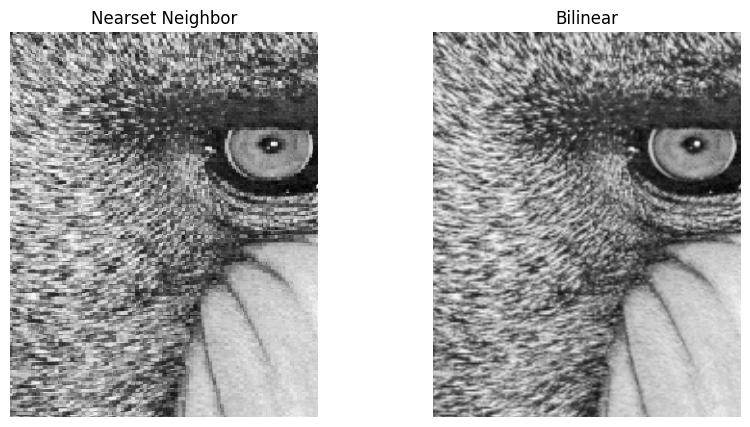

In [93]:
image = io.imread(images_path / 'baboon.png')

sx, sy = 2, 2

S_inv = np.array([[1/sx, 0, 0], [0, 1/sy, 0], [0, 0, 1]])

S = np.array([[sx, 0, 0], [0, sy, 0], [0, 0, 1]])

# Apply the transformation
new_row, new_col = int(row * sy), int(col * sx)
coords, t_coords = gmt_coords(new_row, new_col, S_inv)

t_image_nnb = gmt_nearest_neighbor_interpolation(image, t_coords, (new_row, new_col))
t_image_bl = gmt_bilinear_interpolation(image, t_coords, (new_row, new_col))
# Plot the 3 images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(image, cmap='gray')
# ax[0].axis('off')
ax[0].imshow(t_image_nnb[:400,80:400], cmap='gray')
ax[0].set_title("Nearset Neighbor")
ax[1].imshow(t_image_bl[:400,80:400], cmap='gray')
ax[1].set_title("Bilinear")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

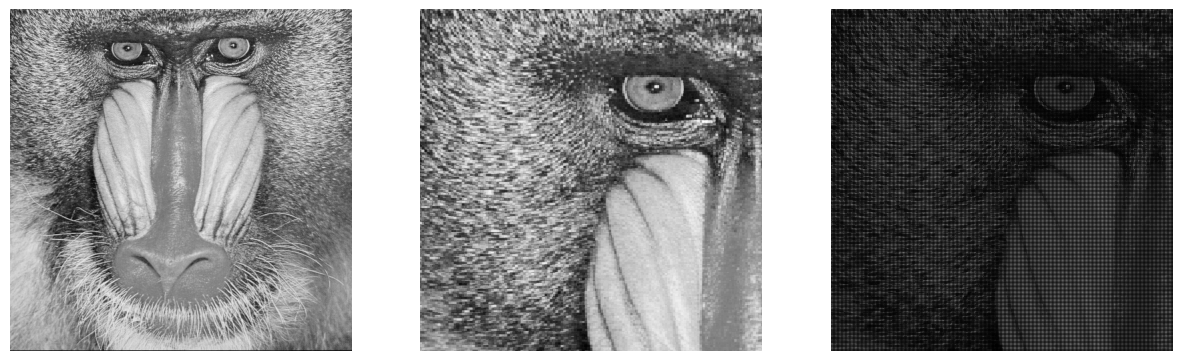

In [9]:
h, w = image.shape[:2]

h_t, w_t = 2*h, 2*w

sx, sy = w_t/w, h_t/h

S_inv = np.array([[1/sx, 0, 0], [0, 1/sy, 0], [0, 0, 1]])

S = np.array([[sx, 0, 0], [0, sy, 0], [0, 0, 1]])

# Apply the transformation
t_image = warp_vet(image, S_inv, inverse=True)
t_image_2 = warp_vet(image, S, inverse=False)

# Plot the 3 images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(t_image, cmap='gray')
ax[1].axis('off')
ax[2].imshow(t_image_2, cmap='gray')
ax[2].axis('off')
plt.show()

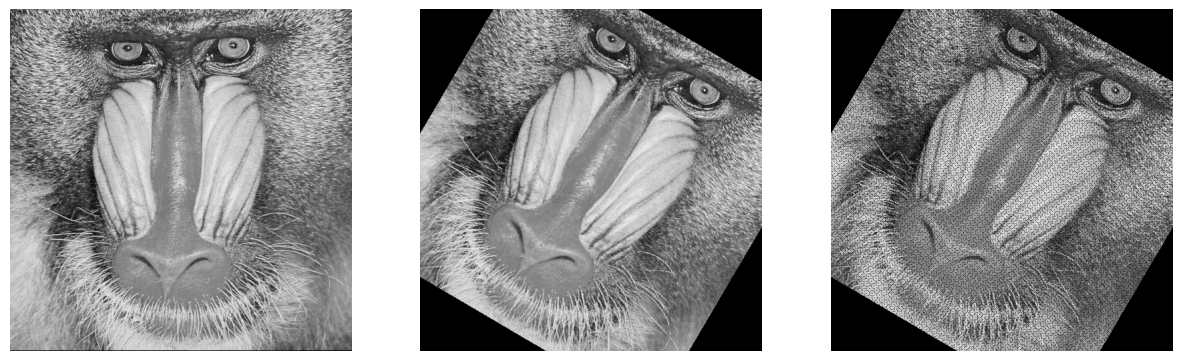

In [5]:
# Define the rotation matrix
theta = 30.433
R = np.array(
    [
        [np.cos(np.deg2rad(theta)), -np.sin(np.deg2rad(theta)), 0],
        [np.sin(np.deg2rad(theta)), np.cos(np.deg2rad(theta)), 0],
        [0, 0, 1],
    ]
)

R_inv = R.T

# Encontre o ponto central da imagem
h, w = image.shape[:2]
cx, cy = w // 2, h // 2

# Transle o ponto central para a origem
T1 = np.array([[1, 0, -cx], [0, 1, -cy], [0, 0, 1]])

M = np.linalg.inv(T1) @ R @ T1

M_inv = np.linalg.inv(M)

# Apply the transformation
t_image = warp_vet(image, M_inv, inverse=True)
t_image_2 = warp_vet(image, M, inverse=False)

# Plot the 3 images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(t_image, cmap='gray')
ax[1].axis('off')
ax[2].imshow(t_image_2, cmap='gray')
ax[2].axis('off')
plt.show()

## 2 Transformações Geométricas

### Bibliotecas

In [73]:
from pathlib import Path
import numpy as np
from skimage import transform, io
from matplotlib import pyplot as plt

### Funções Auxiliares

In [74]:
def open_image(image_path: Path) -> np.ndarray:
    """Abre uma imagem binária e retorna uma matriz numpy.
    Parâmetros:
        image_path: caminho para a imagem
    Retorno:
        Imagem como uma matriz numpy.
    """
    image = io.imread(image_path)
    assert (
        len(image.shape) == 2
    ), f'A Imagem {image_path.name} tem mais de 1 canal'
    # returns a binary version of the image
    return image


def two_images(
    original: np.ndarray,
    processed: np.ndarray,
    t1: str,
    t2: str,
    path: Path = None,
):
    """Visualizar a imagem original versus o resultado do processamento.
    Parâmetros:
        original: imagem original
        processed: imagem processada
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
    fig.tight_layout(pad=0.5)

    axs[0].imshow(original, cmap='gray')
    axs[1].imshow(processed, cmap='gray')

    axs[0].set_title(f'(a) {t1}')
    axs[1].set_title(f'(b) {t2}')

    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()

    if path:
        fig.savefig(path, bbox_inches='tight', pad_inches=0.1)


def histogram(img: np.ndarray, bins: int = 256) -> np.ndarray:
    """Calcula o histograma de uma imagem.
    Parâmetros:
        img: imagem
        bins: número de bins
    """
    return np.histogram(img, bins=bins)[0]


def black_percentual(histogram: np.ndarray) -> float:
    """Calcula o percentual de pixels pretos em uma imagem.
    Parâmetros:
        histogram: histograma da imagem
    Retorno:
        Percentual de pixels pretos.
    """
    return np.round(histogram[0] / histogram.sum(), 4) * 100


def img_and_histogram(
    img: np.ndarray, hist: np.ndarray, title: str, path: Path = None
):
    """Visualizar a imagem e seu histograma.
    Parâmetros:
        img: imagem
        hist: histograma
    """
    fig, axs = plt.subplots(
        nrows=1, ncols=2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]}
    )
    plt.suptitle(title)

    # Image
    axs[0].set_title('(a) Imagem')
    axs[0].imshow(img, cmap='gray')
    axs[0].axis('off')

    # Histogram
    axs[1].set_title('(b) Histograma')
    bins_range = range(hist.shape[0])
    if hist.shape[0] == 2:
        percents = [black_percentual(hist), 100 - black_percentual(hist)]
        bar = axs[1].bar(
            bins_range,
            percents,
            width=1,
            align='center',
            edgecolor='black',
            color='#006AF4',
        )
        axs[1].set_xticks([0, 1], ['preto', 'branco'])
        axs[1].axes.yaxis.set_visible(False)
        axs[1].spines['right'].set_visible(False)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        black_per = f'{percents[0]:.2f}%'
        axs[1].text(
            bar[0].get_x() + bar[0].get_width() / 2,
            bar[0].get_height(),
            black_per,
            ha='center',
            va='bottom',
            fontsize=12,
        )
        white_per = f'{percents[1]:.2f}%'
        axs[1].text(
            bar[1].get_x() + bar[1].get_width() / 2,
            bar[1].get_height(),
            white_per,
            ha='center',
            va='bottom',
            fontsize=12,
        )
    else:
        axs[1].bar(bins_range, hist, color='#006AF4')
        text = f'preto: {black_percentual(hist):.2f}%'
        axs[1].text(
            0.2,
            0.9,
            text,
            transform=axs[1].transAxes,
            color='black',
            fontsize=14,
        )

    plt.show()

    # Save figure
    if path:
        fig.savefig(path, bbox_inches='tight', pad_inches=0.1)


def image_properties(image: np.ndarray):
    """Imprime as propriedades da imagem.
    Parâmetros:
        image: imagem
    """
    print('Propriedades da imagem:')
    print(f'Dimensões: {image.shape}')
    print(f'Tipo de dados: {image.dtype}')
    print(f'Mínimo: {image.min()}')
    print(f'Máximo: {image.max()}')

### Abrir a imagem original

In [75]:
images_path = Path('images')
image = open_image(images_path / 'baboon.png')
image_properties(image)

Propriedades da imagem:
Dimensões: (512, 512)
Tipo de dados: uint8
Mínimo: 0
Máximo: 230


### Transformações Geométricas

#### Rotação

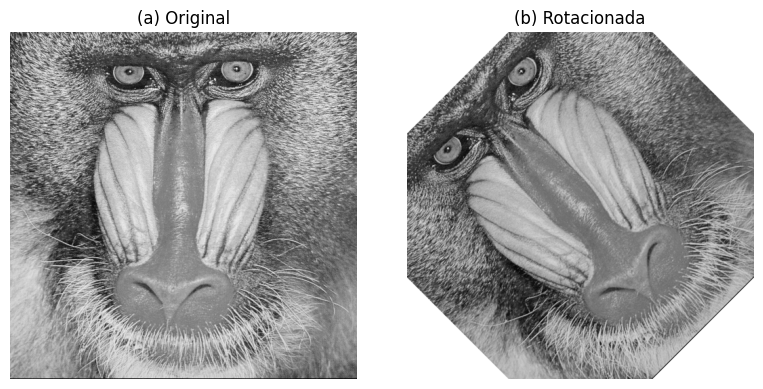

Propriedades da imagem:
Dimensões: (512, 512)
Tipo de dados: float64
Mínimo: 0.013605210779915253
Máximo: 1.0


In [76]:
# Definir angulo de rotação
angle = 45
# Definir o centro de rotação
center = (0, 0)
center = None
mode = ['constant', 'edge', 'symmetric', 'reflect', 'wrap']
# Rotacionar a imagem
image_rotated = transform.rotate(
    image, angle, resize=False, center=center, order=3, mode='constant', cval=1
)

# Visualizar a imagem original e a rotacionada
two_images(image, image_rotated, 'Original', 'Rotacionada')

# propriedades da imagem rotacionada
image_properties(image_rotated)

#### Escala (Fator de escala)

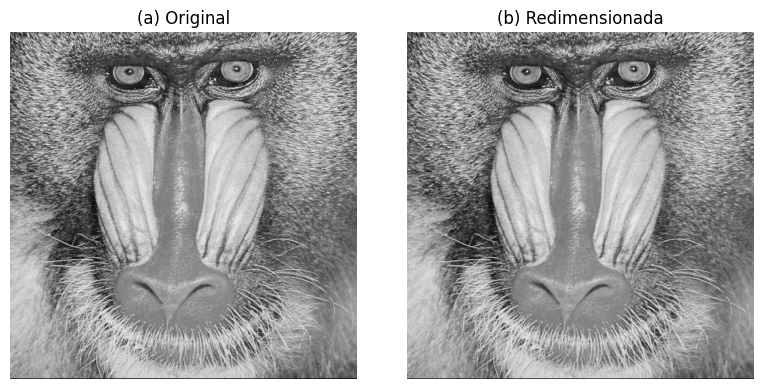

Propriedades da imagem:
Dimensões: (1024, 1024)
Tipo de dados: float64
Mínimo: 0.0
Máximo: 0.9019607843137255


In [78]:
# Definir o fator de escala
scale = 2

# Redimensionar a imagem
image_resized = transform.rescale(
    image, scale, order=3, anti_aliasing=False, mode='constant', cval=1
)

# Visualizar a imagem original e a redimensionada
two_images(image, image_resized, 'Original', 'Redimensionada')

# propriedades da imagem redimensionada
image_properties(image_resized)

#### Escala (Altura, Largura)

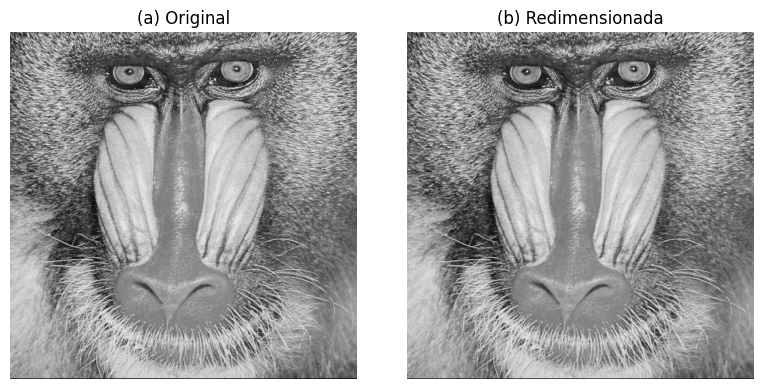

Propriedades da imagem:
Dimensões: (1024, 1024)
Tipo de dados: float64
Mínimo: 0.0
Máximo: 0.9019607843137255


In [84]:
# Definir altura e largura
height, width = 1024, 1024

# Redimensionar a imagem
image_resized = transform.resize(
    image,
    (height, width),
    order=3,
    anti_aliasing=False,
    mode='constant',
    cval=1,
)

# Visualizar a imagem original e a redimensionada
two_images(image, image_resized, 'Original', 'Redimensionada')

# propriedades da imagem redimensionada
image_properties(image_resized)